<font color="red"><b> Unfinished : Read Later

<font size=6><b>Producing an Animated Firing Rate Map

This notebook explains what a animated firing rate map is and explains how to produce one, given a curated dataset. 

# Introduction

## What is a Firing Rate Map?

A firing rate map is a graphical representation of the average firing rate of spike-sorted neurons over a specific time frame, presented on a 2D grid. It helps visualize spatiotemporal patterns of neural activity and aids in understanding the role of individual neurons or groups in brain function.

## What is the value of a Firing Rate Map?

The value of a firing rate map lies in its ability to provide insights into the spatiotemporal patterns of neural activity. By visualizing the average firing rates of spike-sorted neurons on a 2D grid, researchers can identify relationships between neural activity and specific tasks, stimuli, or behavioral states. This helps in understanding how individual neurons or groups contribute to brain function and information processing, thus advancing our knowledge of neural circuits and brain function.

# Method

## Importing data

As an example, we will use a curated dataset from an experiment conducted on live human brain tissue, recorded by a Maxwell MaxOne multi-electrode-array (MEA).

First, let us import the necessary libraries and packages:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import braingeneers
from braingeneers.analysis.analysis import SpikeData, read_phy_files
import braingeneers.data.datasets_electrophysiology as ephys
import scipy.io as sio
import scipy
from scipy.ndimage import gaussian_filter1d
import glob
import pandas as pd
from ipywidgets import interact, interactive, fixed, interact_manual
import random

 The curated dataset is imported as a braingeneers "SpikeData" object, saved as "sd". In this case, let us use the curated dataset 5 from the "2023-04-02-hc328_rec" folder.

In [2]:
sd = read_phy_files('/home/jovyan/data/2023-04-02-hc328_rec/derived/kilosort2/2023_04_02_hc328_5_curated.zip')

## Exploring dataset

We can explore the dataset as follows to get a basic picture of what we are dealing with.

First, we can take a look at the metadata:

In [3]:
metadata = ephys.load_metadata('2023-04-02-hc328_rec')
print(metadata)

{'experiments': [], 'notes': 'first time hckcr1 inhibitory opsin worked on hc', 'timestamp': '2023-04-02T14:25:33', 'uuid': '2023-04-02-hc328_rec', 'ephys_experiments': [{'blocks': [{'num_frames': 823222400, 'path': 'original/experiment1/2023_04_02_hc328_3.raw.h5', 'source': '', 'timestamp': '2023-04-02T14:25:33'}], 'channels': [], 'hardware': 'Maxwell', 'name': 'experiment1', 'notes': '', 'num_channels': 1028, 'num_current_input_channels': 0, 'num_voltage_channels': 1028, 'offset': 0, 'sample_rate': 20000, 'scaler': 1, 'timestamp': '2023-04-02T14:25:33', 'units': 'µV', 'version': '0.0.1'}, {'blocks': [{'num_frames': 823016800, 'path': 'original/experiment2/2023_04_02_hc328_2.raw.h5', 'source': '', 'timestamp': '2023-04-02T14:23:58'}], 'channels': [], 'hardware': 'Maxwell', 'name': 'experiment2', 'notes': '', 'num_channels': 1028, 'num_current_input_channels': 0, 'num_voltage_channels': 1028, 'offset': 0, 'sample_rate': 20000, 'scaler': 1, 'timestamp': '2023-04-02T14:23:58', 'units': '

We can then identify the number of neurons, and the length of the spike train by calling on the attributes of the spike data object.

In [4]:
num_neurons = sd.N
length_spike_train = sd.length

print("Number of neurons: ", num_neurons)
print("Length of spike train in seconds: ", length_spike_train / 1000)

Number of neurons:  72
Length of spike train in seconds:  70.0784


We can also produce plots several plots including the spike raster, interspike interval and correlation matrix to provide a useful visual overview of our dataset.

In [5]:
def plot_raster(sd):
    idces, times = sd.idces_times()
    fig, ax = plt.subplots()

    ax.scatter(times/1000,idces,marker='|',s=1)
    ax.set_xlabel("Time(s)")
    ax.set_ylabel('Unit #')
    plt.show()
    
def interspike(sd):
    # Interspike-intervals of 2 select neurons
    isis_raw = sd.interspike_intervals()
    # Remove all isi's greater than 100ms. As there are likely neurons not following periodic firing pattern
    isis=[]
    for i in range(len(isis_raw)):   
        isi=isis_raw[i]
        isis = isis + isi[isi<100].tolist() 
        
    # Plot the isi's
    plt.xlim(0,100)
    plt.hist(isis, bins=50)
    plt.xlabel('Time bin(ms)')
    plt.ylabel('ISI count')
    plt.show()
    
def correlation(sd):
    # Correlation
    corr = np.zeros((sd.N,sd.N)) #inds by inds

    dense_raster = sd.raster(bin_size=1) # in ms
    sigma = 5                            # Blur it
    dense_raster = gaussian_filter1d(dense_raster.astype(float),sigma=sigma) 
    corr=np.corrcoef( dense_raster )
    
    plt.imshow(corr)
    plt.xlabel("Neuron index")
    plt.ylabel("Neuron index")
    plt.show()
    
def raster_analysis(sd, seconds=20):
    # Zoomed Raster and pop rate
    # Get coordinates for raster
    idces, times = sd.idces_times()

    # Get population rate for everything
    pop_rate = sd.binned(bin_size=1)# in ms
    # Lets smooth this to make it neater
    sigma = 5
    pop_rate_smooth = gaussian_filter1d(pop_rate.astype(float),sigma=sigma) 
    t = np.linspace(0,sd.length,pop_rate.shape[0])/1000

    fig, ax = plt.subplots()

    ax.scatter(times/1000,idces,marker='|',s=1)
    ax2 = ax.twinx()
    ax2.plot(t,pop_rate_smooth,c='r')

    ax.set_xlim(0,seconds)
    ax.set_xlabel("Time(s)")
    ax.set_ylabel('Unit #')
    ax2.set_ylabel('Firing Rate')
    plt.show()
    
def plot_rates(sd):
    rates = sd.rates()
    plt.hist(rates, bins=50)
    plt.xlabel('Firing rate, Hz')
    plt.ylabel('Number neural units')
    plt.show()

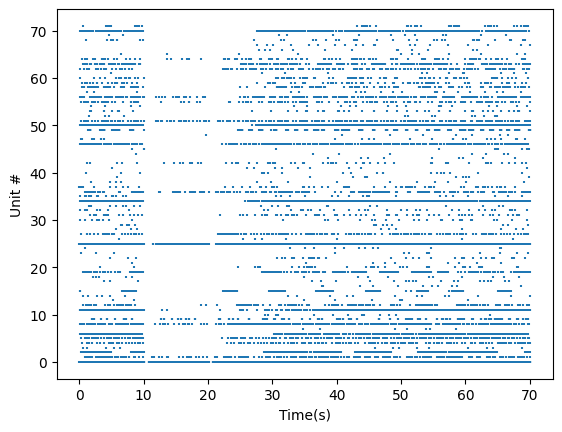

In [6]:
plot_raster(sd)

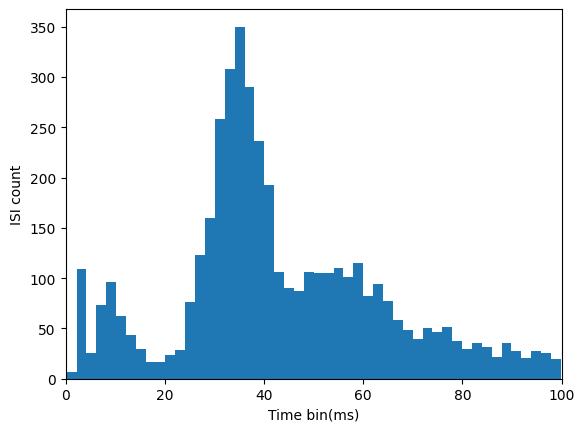

In [7]:
interspike(sd)

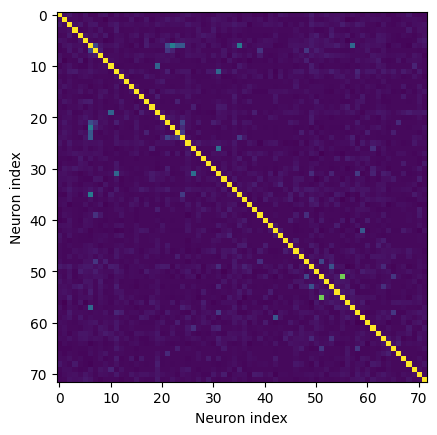

In [8]:
correlation(sd)

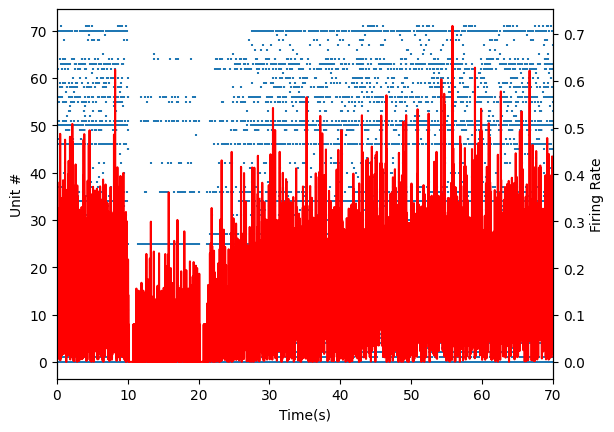

In [9]:
raster_analysis(sd, 70)

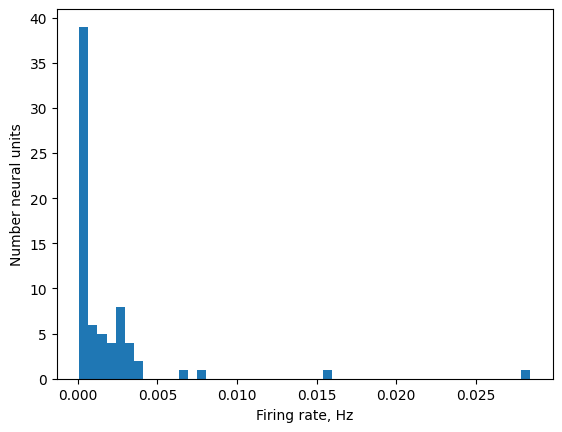

In [10]:
plot_rates(sd)

## Firing Rate Calculation

To calculate the firing rate of a neuron (or neural unit), we divide the number of spikes it generates by the length of the observation period. For example, if neuron 45 fires 25 times in a 5-second period, its firing rate is 5 spikes per second.

## Firing Rate Implementation

The function below takes a spike data object as its input, and uses the "train" and "length" attributes to calculate the firing rate for each neuron in the dataset, before appending each of these values to an array which is returned by the function.

In [11]:
def calculate_mean_firing_rates(spike_data):
    mean_firing_rates = []
    for neuron_spikes in spike_data.train:
        num_spikes = len(neuron_spikes)
        time_duration = spike_data.length / 1000  # Assuming spike times are in milliseconds
        firing_rate = num_spikes / time_duration
        mean_firing_rates.append(firing_rate)

    return np.array(mean_firing_rates)

In [12]:
firing_rates = calculate_mean_firing_rates(sd)

In [13]:
print(firing_rates)

[28.43957625  2.68270965  3.7672093   0.19977625  1.78371652  2.32596635
  2.68270965  0.09988813  3.23922921  3.11080162  0.18550652  7.96251056
  1.6838284   0.11415786  0.27112491  2.69697938  0.15696705  0.29966438
  0.21404598  2.02630197  0.52798009  0.12842759  0.45663143  0.17123679
  0.18550652 15.42558049  0.11415786  1.91214411  0.14269732  0.18550652
  0.4423617   0.97034179  0.52798009  0.29966438  3.85282769  0.4423617
  2.55428206  0.8847234   0.19977625  0.14269732  0.27112491  0.14269732
  0.75629581  0.12842759  0.11415786  0.15696705  2.68270965  0.37101304
  0.11415786  6.35003082  3.46754492  2.42585447  0.18550652  0.74202607
  0.27112491  1.56967054  2.55428206  0.28539464  1.76944679  1.05596018
  1.18438777  0.17123679  1.81225599  3.33911733  1.46978242  0.15696705
  0.18550652  0.28539464  0.51371036  0.18550652  2.69697938  0.57078929]


## Visualization

To create a FCM where each node is labelled as a "receiver", "sender", or "broker", we need to compute the "in-degree" and "out-degree" for each unit. Let us define the "in-degree" as the number of incoming edges, and the "out-degree" as the number of outgoing edges. We can count the number of incoming and outgoing edges for each neuron quite simply - we can look at the number of positive and negative values in the sublist of the latencies array for the given neuron.

In [18]:
def firing_plotter(sd, opacity=0.3, size_factor=10, alpha=0.3):
    neuron_x = []
    neuron_y = []
    firing_rates = calculate_mean_firing_rates(sd)

    for neuron in sd.neuron_data[0].values():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])

    plt.figure(figsize=(8, 6))
    # Increase the 's' parameter to make the scatter points larger
    # Adjust the 'alpha' parameter to control the scatter points' opacity
    plt.scatter(neuron_x, neuron_y, s=firing_rates * size_factor + firing_rates ** 2.3, alpha=opacity, c='r')
    
    plt.show()

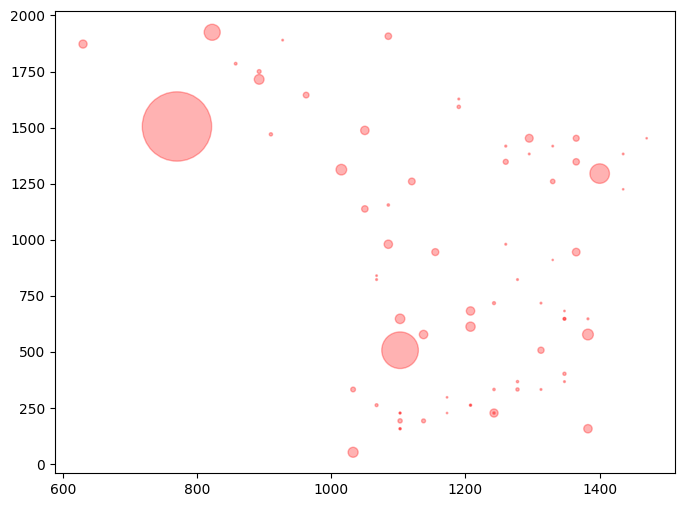

In [17]:
firing_plotter(sd)